In [1]:
import os
import rasterio as rio
import numpy as np
import shapely
import pyproj
import geopandas as gpd
import matplotlib.pyplot as plt
import rioxarray as riox
import rasterio as rio
import xarray as xr
import netCDF4
from osgeo import gdal
import pandas as pd
from datetime import datetime
import snowFun
import dask.array
from rasterio.enums import Resampling
from shapely.geometry import box
# %matplotlib widget

# define folder and file paths
folder_AGVA = os.path.join('C:',os.sep,'Users','lzell','OneDrive - Colostate','Desktop',"AGVA")
folder_dems = os.path.join(folder_AGVA, "DEMs", "time_varying_DEMs", "10m")
folder_class = os.path.join(folder_AGVA, 'classified images', 'S2_Classified_Cloudmasked_Merged')
folder_cloud = os.path.join(folder_AGVA, 'classified images', 'S2_Cloud_Merged')
folder_meta = os.path.join(folder_AGVA, "classified images", "meta csv", "S2")
folder_climate = os.path.join(folder_AGVA, "Climate")

# open rgi
path_rgi = os.path.join(folder_AGVA, 'RGI', "rgi_2km_o3regions", "rgi_2km_o3regions.shp")
rgi_gdf = gpd.read_file(path_rgi, include_fields=['RGIId', 'geometry'])

# open the daily temp and precip data
path_t = os.path.join(folder_climate, "era5land_daily_temp_2018_2022.tif")
path_p = os.path.join(folder_climate, "era5land_daily_precip_2018_2022.tif")
path_z = os.path.join(folder_climate, "geo_1279l4_0.1x0.1.grib2_v4_unpack.nc")

t_xr = riox.open_rasterio(path_t).rename({'band':'time'})
p_xr = riox.open_rasterio(path_p).rename({'band':'time'})

# create list of dates
dates = pd.date_range(start="2018-01-01", end='2022-12-31', freq='D')
print(len(dates), len(t_xr.time))

t_xr['time']=dates
p_xr['time']=dates

# make copy to save
t_xr_orig = t_xr.copy()
p_xr_orig = p_xr.copy()

# reproject to alaska albers
t_xr.rio.write_nodata(np.nan, inplace=True)
p_xr.rio.write_nodata(np.nan, inplace=True)
t_xr = t_xr.rio.reproject('EPSG:3338', resampling=Resampling.bilinear, nodata=np.nan)
p_xr = p_xr.rio.reproject('EPSG:3338', resampling=Resampling.bilinear, nodata=np.nan)
t_xr = t_xr.sel( x=slice(-450000, 1661000), y=slice(1652000,500000) )
p_xr = p_xr.sel( x=slice(-450000, 1661000), y=slice(1652000,500000) )

# p_xr = p_xr.sel( x=slice(210,215), y=slice(65,60) )
# t_xr = t_xr.sel( x=slice(210,215), y=slice(65,60) )

1826 1826


In [2]:
import importlib
importlib.reload(snowFun)

<module 'snowFun' from 'C:\\Users\\lzell\\OneDrive - Colostate\\Desktop\\AGVA\\scripts\\snowFun\\__init__.py'>

In [3]:
t_2018_s = t_xr.sel(time=slice("2018-06-01", "2018-09-30"))
t_2019_s = t_xr.sel(time=slice("2019-06-01", "2019-09-30"))
t_2020_s = t_xr.sel(time=slice("2020-06-01", "2020-09-30"))
t_2021_s = t_xr.sel(time=slice("2021-06-01", "2021-09-30"))
t_2022_s = t_xr.sel(time=slice("2022-06-01", "2022-09-30"))

t_2018_w = t_xr.sel(time=slice("2018-01-01", "2018-04-30"))
t_2019_w = t_xr.sel(time=slice("2019-01-01", "2019-04-30"))
t_2020_w = t_xr.sel(time=slice("2020-01-01", "2020-04-30"))
t_2021_w = t_xr.sel(time=slice("2021-01-01", "2021-04-30"))
t_2022_w = t_xr.sel(time=slice("2022-01-01", "2022-04-30"))

p_2018_s = p_xr.sel(time=slice("2018-06-01", "2018-09-30"))
p_2019_s = p_xr.sel(time=slice("2019-06-01", "2019-09-30"))
p_2020_s = p_xr.sel(time=slice("2020-06-01", "2020-09-30"))
p_2021_s = p_xr.sel(time=slice("2021-06-01", "2021-09-30"))
p_2022_s = p_xr.sel(time=slice("2022-06-01", "2022-09-30"))

p_2018_w = p_xr.sel(time=slice("2018-01-01", "2018-04-30"))
p_2019_w = p_xr.sel(time=slice("2019-01-01", "2019-04-30"))
p_2020_w = p_xr.sel(time=slice("2020-01-01", "2020-04-30"))
p_2021_w = p_xr.sel(time=slice("2021-01-01", "2021-04-30"))
p_2022_w = p_xr.sel(time=slice("2022-01-01", "2022-04-30"))

t_s_avg = xr.concat([t_2018_s, t_2019_s, t_2020_s, t_2021_s, t_2022_s], dim='time').mean(dim='time')
t_w_avg = xr.concat([t_2018_w, t_2019_w, t_2020_w, t_2021_w, t_2022_w], dim='time').mean(dim='time')
p_s_avg = xr.concat([p_2018_s, p_2019_s, p_2020_s, p_2021_s, p_2022_s], dim='time').mean(dim='time')
p_w_avg = xr.concat([p_2018_w, p_2019_w, p_2020_w, p_2021_w, p_2022_w], dim='time').mean(dim='time')

# then calculate anomalies
t_2018_s_anom = t_2018_s.mean(dim='time') - t_s_avg
t_2019_s_anom = t_2019_s.mean(dim='time') - t_s_avg
t_2020_s_anom = t_2020_s.mean(dim='time') - t_s_avg
t_2021_s_anom = t_2021_s.mean(dim='time') - t_s_avg
t_2022_s_anom = t_2022_s.mean(dim='time') - t_s_avg

t_2018_w_anom = t_2018_w.mean(dim='time') - t_w_avg
t_2019_w_anom = t_2019_w.mean(dim='time') - t_w_avg
t_2020_w_anom = t_2020_w.mean(dim='time') - t_w_avg
t_2021_w_anom = t_2021_w.mean(dim='time') - t_w_avg
t_2022_w_anom = t_2022_w.mean(dim='time') - t_w_avg

p_2018_s_anom = p_2018_s.mean(dim='time') - p_s_avg
p_2019_s_anom = p_2019_s.mean(dim='time') - p_s_avg
p_2020_s_anom = p_2020_s.mean(dim='time') - p_s_avg
p_2021_s_anom = p_2021_s.mean(dim='time') - p_s_avg
p_2022_s_anom = p_2022_s.mean(dim='time') - p_s_avg

p_2018_w_anom = p_2018_w.mean(dim='time') - p_w_avg
p_2019_w_anom = p_2019_w.mean(dim='time') - p_w_avg
p_2020_w_anom = p_2020_w.mean(dim='time') - p_w_avg
p_2021_w_anom = p_2021_w.mean(dim='time') - p_w_avg
p_2022_w_anom = p_2022_w.mean(dim='time') - p_w_avg

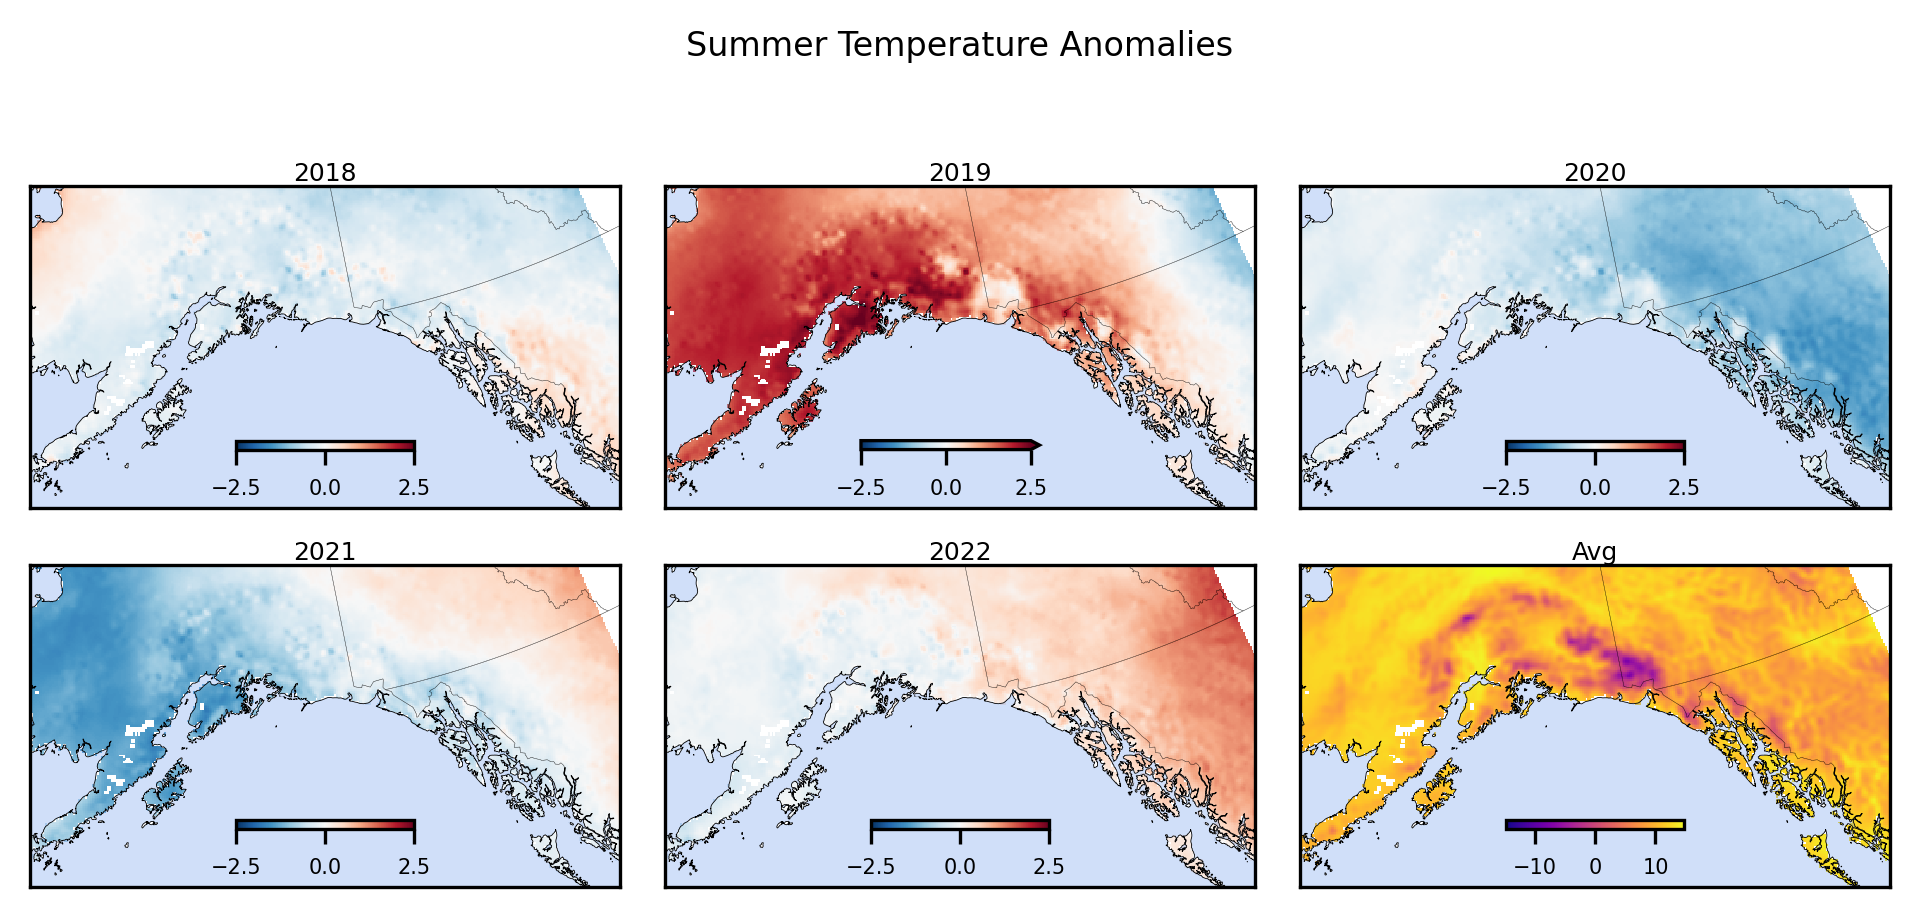

In [45]:
### summer temperature anomalies
fig,axs = snowFun.create_annual_base_maps(hillshade=0)
ax18,ax19,ax20,ax21,ax22,axav = [a for ax in axs for a in ax] # flatten out everything
all_axs = [ax18,ax19,ax20,ax21,ax22,axav]

cmap="RdBu_r"
vmin=-2.5
vmax=2.5

t_2018_s_anom.plot(ax=ax18, cmap=cmap, vmin=vmin, vmax=vmax,
                            cbar_kwargs={"location":'bottom', "fraction":0.02, 'pad':-0.15})
t_2019_s_anom.plot(ax=ax19, cmap=cmap, vmin=vmin, vmax=vmax,
                            cbar_kwargs={"location":'bottom', "fraction":0.02, 'pad':-0.15})
t_2020_s_anom.plot(ax=ax20, cmap=cmap, vmin=vmin, vmax=vmax,
                            cbar_kwargs={"location":'bottom', "fraction":0.02, 'pad':-0.15})
t_2021_s_anom.plot(ax=ax21, cmap=cmap, vmin=vmin, vmax=vmax,
                            cbar_kwargs={"location":'bottom', "fraction":0.02, 'pad':-0.15})
t_2022_s_anom.plot(ax=ax22, cmap=cmap, vmin=vmin, vmax=vmax,
                            cbar_kwargs={"location":'bottom', "fraction":0.02, 'pad':-0.15})
(t_s_avg-273.15).plot(ax=axav, cmap='plasma', cbar_kwargs={"location":'bottom', "fraction":0.02, 'pad':-0.15})

# format colorbar in each axes
for ax in fig.axes[-6:]:
    ax.tick_params(labelsize=5)

# format x and y labels, titles
titles = ['2018', '2019', '2020', '2021', '2022', 'Avg']
c = 0
for ax in all_axs:
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_title(titles[c], size='6', pad=0)
    c+=1
    
plt.figtext(0.5,0.9, "Summer Temperature Anomalies", ha='center', size=8)
    
plt.tight_layout()

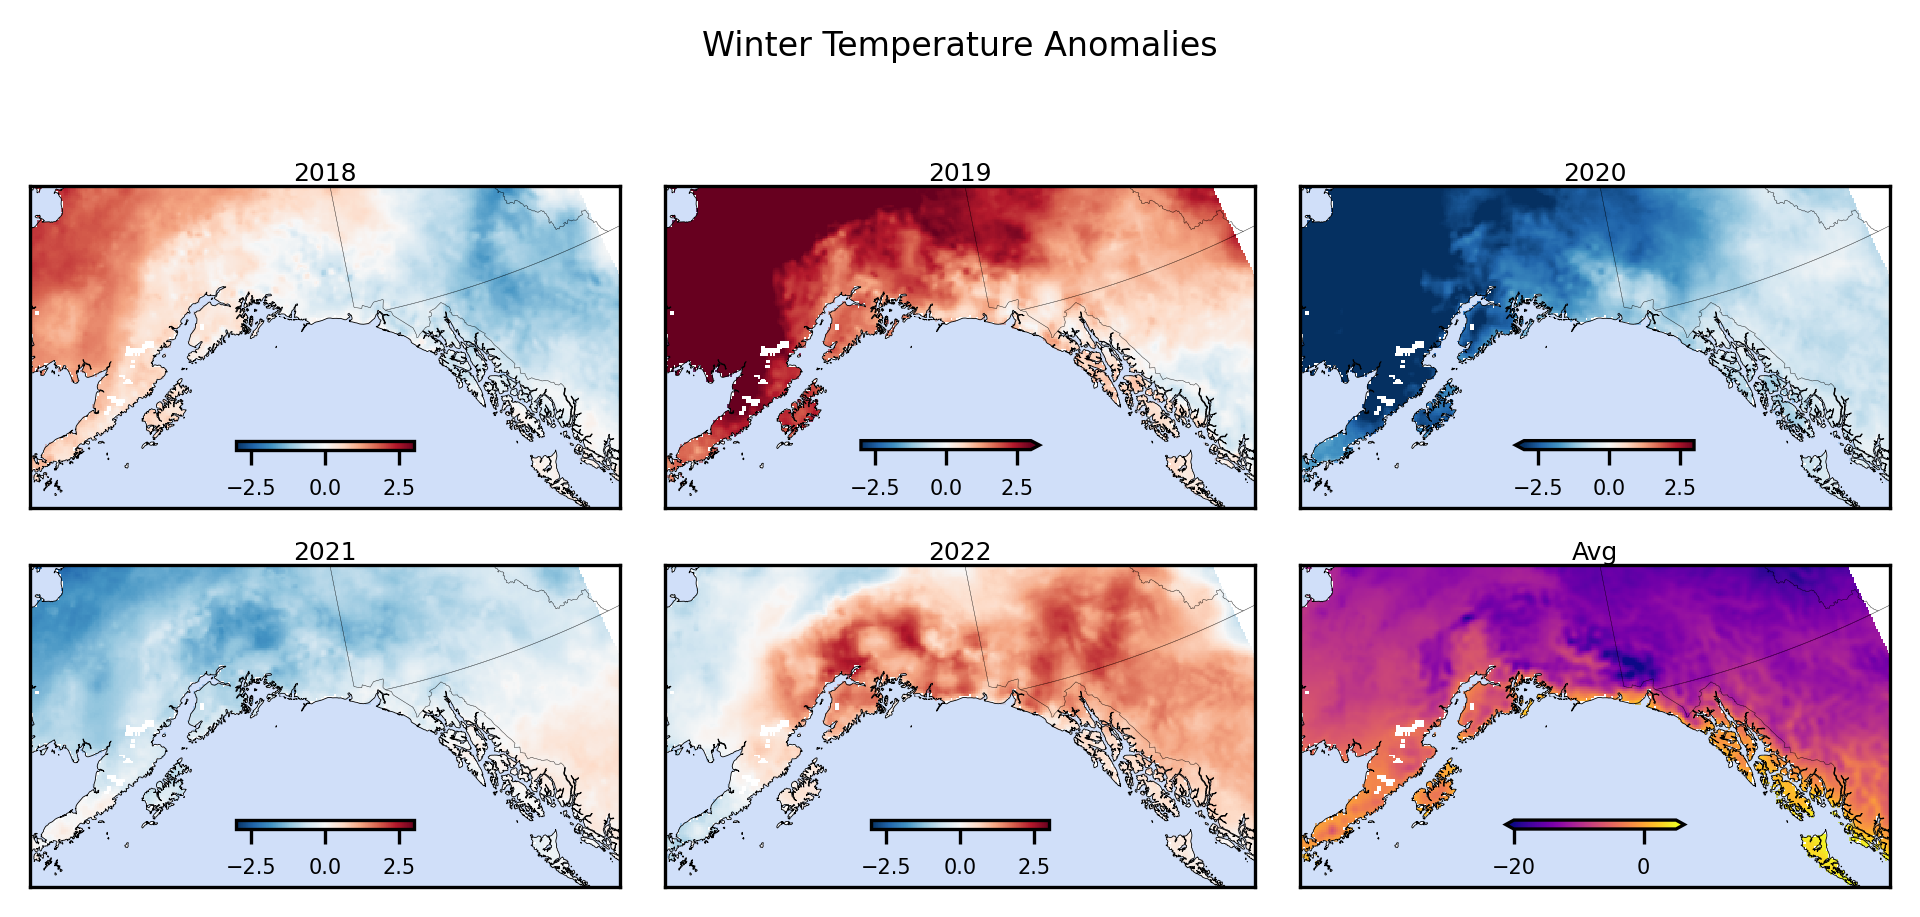

In [48]:
### winter temperature anomalies
fig,axs = snowFun.create_annual_base_maps(hillshade=0)
ax18,ax19,ax20,ax21,ax22,axav = [a for ax in axs for a in ax] # flatten out everything
all_axs = [ax18,ax19,ax20,ax21,ax22,axav]

cmap="RdBu_r"
vmin=-3
vmax=3

t_2018_w_anom.plot(ax=ax18, cmap=cmap, vmin=vmin, vmax=vmax,
                            cbar_kwargs={"location":'bottom', "fraction":0.02, 'pad':-0.15})
t_2019_w_anom.plot(ax=ax19, cmap=cmap, vmin=vmin, vmax=vmax,
                            cbar_kwargs={"location":'bottom', "fraction":0.02, 'pad':-0.15})
t_2020_w_anom.plot(ax=ax20, cmap=cmap, vmin=vmin, vmax=vmax,
                            cbar_kwargs={"location":'bottom', "fraction":0.02, 'pad':-0.15})
t_2021_w_anom.plot(ax=ax21, cmap=cmap, vmin=vmin, vmax=vmax,
                            cbar_kwargs={"location":'bottom', "fraction":0.02, 'pad':-0.15})
t_2022_w_anom.plot(ax=ax22, cmap=cmap, vmin=vmin, vmax=vmax,
                            cbar_kwargs={"location":'bottom', "fraction":0.02, 'pad':-0.15})
(t_w_avg-273.15).plot(ax=axav, cmap='plasma', vmin=-20, vmax=5,
                      cbar_kwargs={"location":'bottom', "fraction":0.02, 'pad':-0.15})

# format colorbar in each axes
for ax in fig.axes[-6:]:
    ax.tick_params(labelsize=5)

# format x and y labels, titles
titles = ['2018', '2019', '2020', '2021', '2022', 'Avg']
c = 0
for ax in all_axs:
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_title(titles[c], size='6', pad=0)
    c+=1
    
plt.figtext(0.5,0.9, "Winter Temperature Anomalies", ha='center', size=8)
plt.tight_layout()

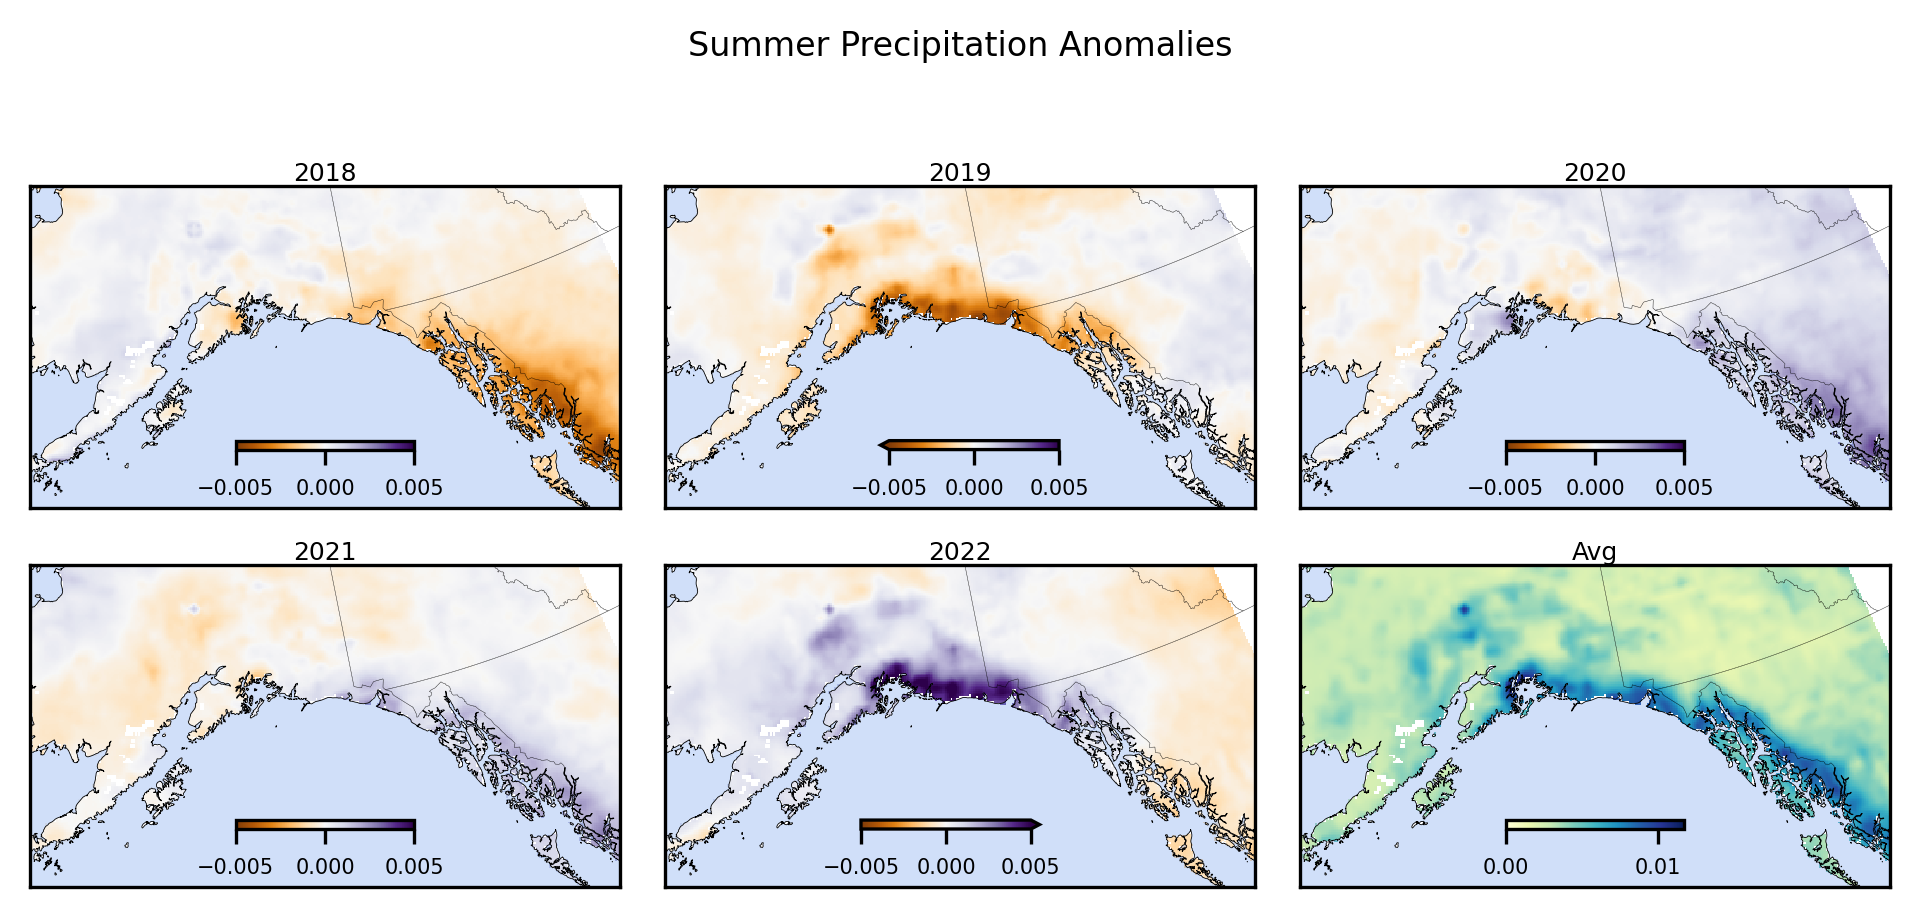

In [21]:
### summer precip anomalies
fig,axs = snowFun.create_annual_base_maps(hillshade=0)
ax18,ax19,ax20,ax21,ax22,axav = [a for ax in axs for a in ax] # flatten out everything
all_axs = [ax18,ax19,ax20,ax21,ax22,axav]

cmap="PuOr"
vmin=-0.005
vmax=0.005

p_2018_s_anom.plot(ax=ax18, cmap=cmap, vmin=vmin, vmax=vmax,
                            cbar_kwargs={"location":'bottom', "fraction":0.02, 'pad':-0.15})
p_2019_s_anom.plot(ax=ax19, cmap=cmap, vmin=vmin, vmax=vmax,
                            cbar_kwargs={"location":'bottom', "fraction":0.02, 'pad':-0.15})
p_2020_s_anom.plot(ax=ax20, cmap=cmap, vmin=vmin, vmax=vmax,
                            cbar_kwargs={"location":'bottom', "fraction":0.02, 'pad':-0.15})
p_2021_s_anom.plot(ax=ax21, cmap=cmap, vmin=vmin, vmax=vmax,
                            cbar_kwargs={"location":'bottom', "fraction":0.02, 'pad':-0.15})
p_2022_s_anom.plot(ax=ax22, cmap=cmap, vmin=vmin, vmax=vmax,
                            cbar_kwargs={"location":'bottom', "fraction":0.02, 'pad':-0.15})
p_s_avg.plot(ax=axav, cmap='YlGnBu', vmin=0, cbar_kwargs={"location":'bottom', "fraction":0.02, 'pad':-0.15})

# format colorbar in each axes
for ax in fig.axes[-6:]:
    ax.tick_params(labelsize=5)

# format x and y labels, titles
titles = ['2018', '2019', '2020', '2021', '2022', 'Avg']
c = 0
for ax in all_axs:
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_title(titles[c], size='6', pad=0)
    c+=1
    
plt.figtext(0.5,0.9, "Summer Precipitation Anomalies", ha='center', size=8)
plt.tight_layout()

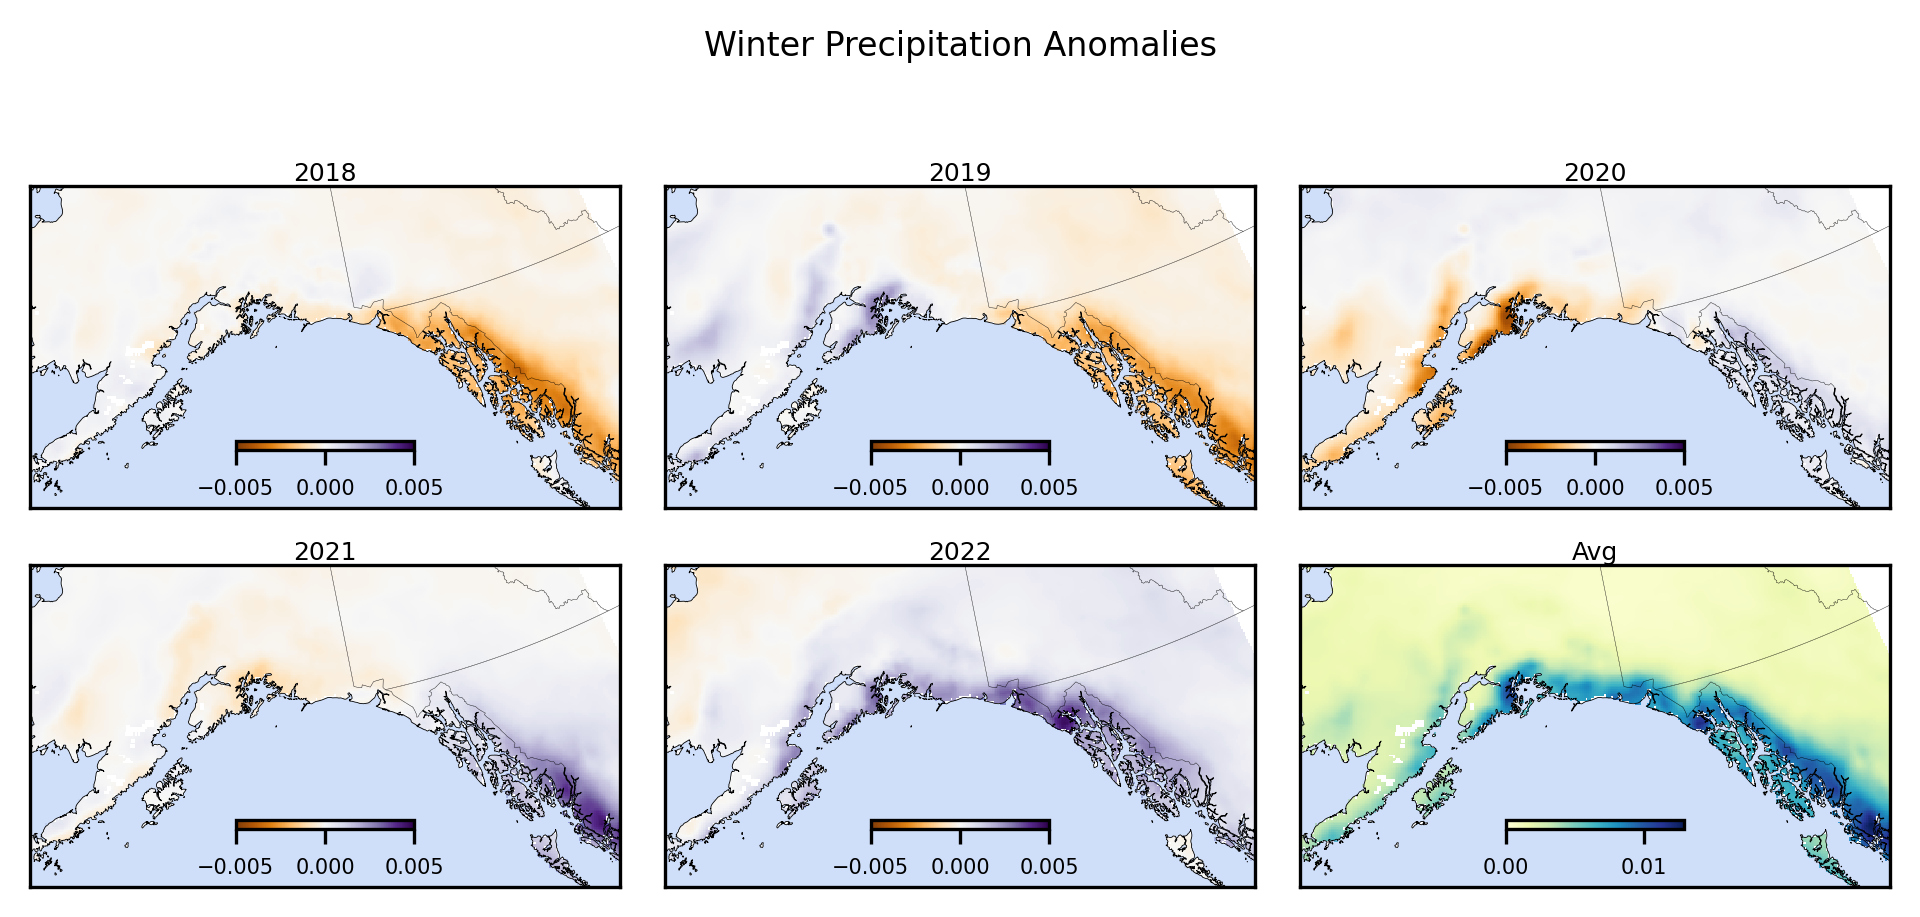

In [22]:
### winter precip anomalies
fig,axs = snowFun.create_annual_base_maps(hillshade=0)
ax18,ax19,ax20,ax21,ax22,axav = [a for ax in axs for a in ax] # flatten out everything
all_axs = [ax18,ax19,ax20,ax21,ax22,axav]

cmap="PuOr"
vmin=-0.005
vmax=0.005

p_2018_w_anom.plot(ax=ax18, cmap=cmap, vmin=vmin, vmax=vmax,
                            cbar_kwargs={"location":'bottom', "fraction":0.02, 'pad':-0.15})
p_2019_w_anom.plot(ax=ax19, cmap=cmap, vmin=vmin, vmax=vmax,
                            cbar_kwargs={"location":'bottom', "fraction":0.02, 'pad':-0.15})
p_2020_w_anom.plot(ax=ax20, cmap=cmap, vmin=vmin, vmax=vmax,
                            cbar_kwargs={"location":'bottom', "fraction":0.02, 'pad':-0.15})
p_2021_w_anom.plot(ax=ax21, cmap=cmap, vmin=vmin, vmax=vmax,
                            cbar_kwargs={"location":'bottom', "fraction":0.02, 'pad':-0.15})
p_2022_w_anom.plot(ax=ax22, cmap=cmap, vmin=vmin, vmax=vmax,
                            cbar_kwargs={"location":'bottom', "fraction":0.02, 'pad':-0.15})
p_w_avg.plot(ax=axav, cmap='YlGnBu', vmin=0, cbar_kwargs={"location":'bottom', "fraction":0.02, 'pad':-0.15})

# format colorbar in each axes
for ax in fig.axes[-6:]:
    ax.tick_params(labelsize=5)

# format x and y labels, titles
titles = ['2018', '2019', '2020', '2021', '2022', 'Avg']
c = 0
for ax in all_axs:
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_title(titles[c], size='6', pad=0)
    c+=1
    
plt.figtext(0.5,0.9, "Winter Precipitation Anomalies", ha='center', size=8)
plt.tight_layout()

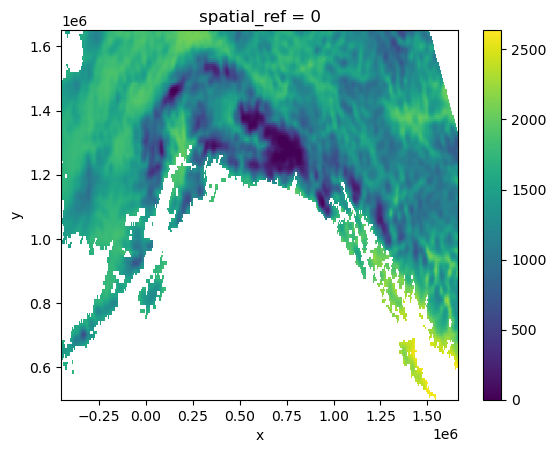

In [42]:
# calculate PDDs each year
pdd_2018 = t_xr.sel(time=slice("2018-01-01", "2018-09-30"))-273.15  
pdd_2018 = xr.where(pdd_2018.isnull(), np.nan, pdd_2018.where(pdd_2018>=0, 0)).sum(dim='time', skipna=False)  
pdd_2018.plot()

In [ ]:
# fig,axs = snowFun.create_annual_base_maps(hillshade=0)
fig,axs = plt.subplots(2,3, figsize=(6.5,4))
ax18,ax19,ax20,ax21,ax22,axav = [a for ax in axs for a in ax] # flatten out everything
all_axs = [ax18,ax19,ax20,ax21,ax22,axav]

t_2018_s_anom.plot(ax=ax18, cbar_kwargs={"location":'bottom', "fraction":0.02, 'pad':-0.15})
t_2019_s_anom.plot(ax=ax19, cbar_kwargs={"location":'bottom', "fraction":0.02, 'pad':-0.15})
t_2020_s_anom.plot(ax=ax20, cbar_kwargs={"location":'bottom', "fraction":0.02, 'pad':-0.15})
t_2021_s_anom.plot(ax=ax21, cbar_kwargs={"location":'bottom', "fraction":0.02, 'pad':-0.15})
t_2022_s_anom.plot(ax=ax22, cbar_kwargs={"location":'bottom', "fraction":0.02, 'pad':-0.15})
t_s_avg.plot(ax=axav, cbar_kwargs={"location":'bottom', "fraction":0.02, 'pad':-0.15})

# format colorbar in each axes
for ax in fig.axes[-6:]:
    ax.tick_params(labelsize=5)

# format x and y labels
for ax in all_axs:
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_title("")
    
plt.figtext(0.5,0.9, "Summer Temperature Anomalies", ha='center', size=8)
plt.tight_layout()

In [ ]:
def raster_to_gdf(xr_data):

    # Extract spatial information
    transform = xr_data.rio.transform()
    crs = xr_data.rio.crs

    # Create a meshgrid of coordinates
    x, y = xr.broadcast(xr_data.coords['x'], xr_data.coords['y'])


    # Flatten the meshgrid and the temperature values
    x_flat = x.values.flatten().round(1)
    y_flat = y.values.flatten().round(1)
    temp_values = xr_data.values.T.flatten()

    # Create a GeoDataFrame
    geometry = [ box(x, y, x+0.1, y-0.1) for x, y in zip(x_flat, y_flat) ]
    gdf = gpd.GeoDataFrame({'data': temp_values}, geometry=geometry, crs=crs)
    
    return gdf


In [ ]:
# test = raster_to_gdf(t_2018_s_anom).to_crs("EPSG:3338")

fig,axs = snowFun.create_annual_base_maps(hillshade=0)
ax18,ax19,ax20,ax21,ax22,axav = [a for ax in axs for a in ax] # flatten out everything
all_axs = [ax18,ax19,ax20,ax21,ax22,axav]

raster_to_gdf(t_2018_s_anom).to_crs("EPSG:3338").plot(ax=ax18, column='data', edgecolor='face',
                                                      zorder=10, cmap='coolwarm', legend=True, vmin=-1.5, vmax=1.5,
                                                      legend_kwds={"location":'bottom', "fraction":0.02, 'pad':-0.15})

raster_to_gdf(t_2019_s_anom).to_crs("EPSG:3338").plot(ax=ax19, column='data', edgecolor='face',
                                                      zorder=10, cmap='coolwarm', legend=True, vmin=-1.5, vmax=1.5,
                                                      legend_kwds={"location":'bottom', "fraction":0.02, 'pad':-0.15})

raster_to_gdf(t_2020_s_anom).to_crs("EPSG:3338").plot(ax=ax20, column='data', edgecolor='face',
                                                      zorder=10, cmap='coolwarm', legend=True, vmin=-1.5, vmax=1.5,
                                                      legend_kwds={"location":'bottom', "fraction":0.02, 'pad':-0.15})

raster_to_gdf(t_2021_s_anom).to_crs("EPSG:3338").plot(ax=ax21, column='data', edgecolor='face',
                                                      zorder=10, cmap='coolwarm', legend=True, vmin=-1.5, vmax=1.5,
                                                      legend_kwds={"location":'bottom', "fraction":0.02, 'pad':-0.15})

raster_to_gdf(t_2022_s_anom).to_crs("EPSG:3338").plot(ax=ax22, column='data', edgecolor='face',
                                                      zorder=10, cmap='coolwarm', legend=True, vmin=-1.5, vmax=1.5,
                                                      legend_kwds={"location":'bottom', "fraction":0.02, 'pad':-0.15})

raster_to_gdf(t_s_avg).to_crs("EPSG:3338").plot(ax=axav, column='data', edgecolor='face',
                                                      zorder=10, cmap='plasma', legend=True,
                                                      legend_kwds={"location":'bottom', "fraction":0.02, 'pad':-0.15})

# t_2018_s_anom.plot(ax=ax18, cbar_kwargs={"location":'bottom', "fraction":0.02, 'pad':-0.15})
# t_2019_s_anom.plot(ax=ax19, cbar_kwargs={"location":'bottom', "fraction":0.02, 'pad':-0.15})
# t_2020_s_anom.plot(ax=ax20, cbar_kwargs={"location":'bottom', "fraction":0.02, 'pad':-0.15})
# t_2021_s_anom.plot(ax=ax21, cbar_kwargs={"location":'bottom', "fraction":0.02, 'pad':-0.15})
# t_2022_s_anom.plot(ax=ax22, cbar_kwargs={"location":'bottom', "fraction":0.02, 'pad':-0.15})
# t_s_avg.plot(ax=axav, cbar_kwargs={"location":'bottom', "fraction":0.02, 'pad':-0.15})

# format colorbar in each axes
for ax in fig.axes[-6:]:
    ax.tick_params(labelsize=5)

# format x and y labels
for ax in all_axs:
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_title("")
    
plt.figtext(0.5,0.9, "Summer Temperature Anomalies", ha='center', size=8)
plt.tight_layout()